In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
# Standard imports
import numpy as np
import pylab as plt
import torch

# Set randomness
np.random.seed(25)
torch.manual_seed(25)

# Import swyft
import swyft
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def simulator(v, w = 0.03):
    "Ring simulator"
    x1, y1, r = v
    
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    
    # Add random distortions in terms of lines
    for _ in range(20):
        xr = np.random.rand(2)
        mu += 0.8*np.exp(-(X*xr[0]+Y*(1-xr[0])-xr[1])**2/0.01**2)
        
    return dict(x=np.array(mu))

In [4]:
sim = swyft.Simulator(simulator, ["x1", "y1", "r"], sim_shapes = dict(x=(32, 32)))

In [5]:
prior = swyft.Prior(lambda u: u*np.array([1., 1., 0.5]), 3)

In [6]:
store = swyft.MemoryStore(sim)
store.add(10000, prior)
store.simulate()

Creating new store.
Store: Adding 10130 new samples to simulator store.


In [7]:
def noise(obs, v, sigma=0.1):
    mu = obs['x']
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return dict(x=x)

In [8]:
dataset = swyft.Dataset(10000, prior, store, simhook = noise)
post = swyft.Posteriors(dataset)

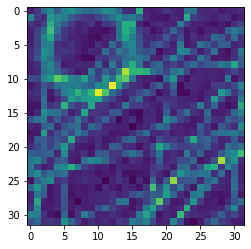

In [9]:
plt.imshow(dataset[0][0]['x'])

In [10]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 160
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([32,32]))
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)

    def forward(self, obs):
        x=obs['x']
        x = self.onl_f(x)
        
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [11]:
marginals = [0, 1, 2]
post.add(marginals, device = DEVICE, head = Head)
post.train(marginals, max_epochs = 10)

/home/weniger/miniconda3/lib/python3.7/site-packages/torch-1.9.0-py3.7-linux-x86_64.egg/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: lr=0.001, Epoch=10, VL=2.015


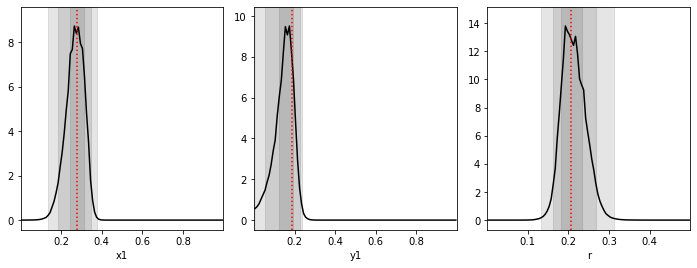

In [12]:
i = 0
obs0 = dataset[i][0]
v0 = dataset[i][2]
samples=post.sample(100000, obs0)
swyft.plot_1d(samples, [0, 1, 2], truth = v0, figsize = (12, 4), bins = 100);

In [13]:
marginals_2d = [(0, 1), (0, 2), (1, 2)]
post.add(marginals_2d, device = DEVICE, head = Head)
post.train(marginals_2d, max_epochs = 20)

Training: lr=0.001, Epoch=20, VL=1.348


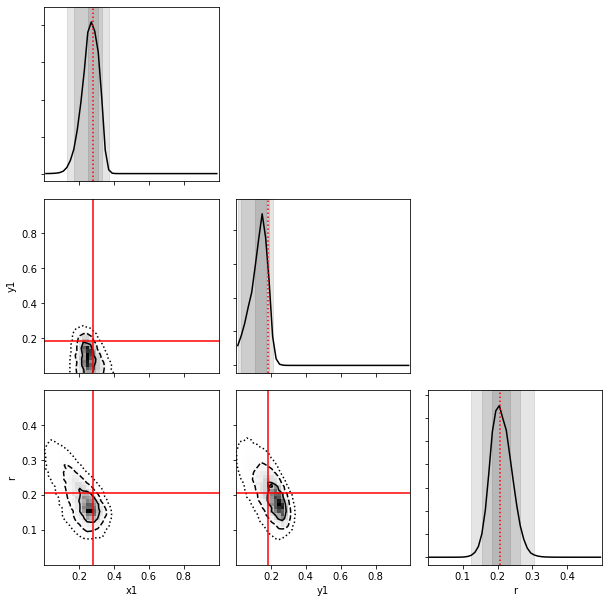

In [14]:
i = 0
obs0 = dataset[i][0]
v0 = dataset[i][2]
samples = post.sample(100000, obs0)
swyft.plot_corner(samples, [0, 1, 2], truth = v0, bins = 50);